# Haplotype analysis for genes in high-$PBS$ regions

## Input

Input files and parameters:

In [1]:
# output
outdir   = "results_pbs_candidates" # where to store output
popc     = "population"

# gene of interest
chrom     = "3L"
l_nom     = "3Lregion-C" # nom loci
loc_start = 35702128     # start gene
loc_end   = 35734762     # end gene

# input data phase1
oc_metasam_fn = "../metadata/samples.meta_phenotypes_acegenotype.simple.txt"
oc_hapcall_fn = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/haplotypes/zarr2/ag1000g.phase2.ar1.samples/"
oc_accessi_fn = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/accessibility/accessibility.h5"
oc_popc       = popc
oc_popl       = ["CIcol"]

# gff
gffann_fn  = "../metadata/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.9.gff3"

In [2]:
import numpy as np
import pandas as pd
import allel
import h5py
import zarr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import itertools
from scipy.spatial.distance import squareform

# load plot settings
sns.set(context="notebook",style="ticks",
        font_scale=1,font="Arial",palette="bright")

## Load data

### Phase1 variants

Population and sample data:

In [3]:
# load samples list with sample code, groupings, locations etc.
oc_samples_df   = pd.read_csv(oc_metasam_fn, sep='\t')
oc_samples_bool = (oc_samples_df[oc_popc].isin(oc_popl).values)
oc_samples      = oc_samples_df[oc_samples_bool]
oc_samples.reset_index(drop=True, inplace=True)

# indexed dictionary of populations
oc_popdict = dict()
for popi in oc_popl: 
    oc_popdict[popi]  = oc_samples[oc_samples[oc_popc] == popi].index.tolist()

# add an extra population composed of all other locations
oc_popdict["all"] = []
for popi in oc_popl:
    oc_popdict["all"] = oc_popdict["all"] + oc_popdict[popi]


# report
print("Data:")
print("* Samples     = ", oc_samples.shape[0])
print("* Populations = ", set(oc_samples[oc_popc]))
print(oc_samples.groupby(("population")).size())

Data:
* Samples     =  71
* Populations =  {'CIcol'}
population
CIcol    71
dtype: int64


Phased variants and genotypes:

In [4]:
# declare objects with variant data
oc_hapcall   = zarr.open(oc_hapcall_fn)
# variants of genotypes
print("Variants phased...")
oc_hapcall_var = oc_hapcall[chrom]["variants"]
oc_hapvars = allel.VariantChunkedTable(oc_hapcall_var,names=["POS","REF","ALT"],index="POS") 
print(oc_hapvars.shape)
# genotype data
print("Genotypes phased...")
oc_hapcall_hap = oc_hapcall[chrom]["calldata"]["genotype"]
oc_haploty     = allel.GenotypeChunkedArray(oc_hapcall_hap) 
oc_haploty     = oc_haploty.subset(sel1=oc_samples_bool)
print(oc_haploty.shape)

Variants phased...
(7897666,)
Genotypes phased...
(7897666, 71, 2)


Get haplotypes from phased variants:

In [5]:
# recast haplotypes: drop ploidy
print("Expand phase haplotypes...")
oc_haploty_hap = oc_haploty.to_haplotypes()
print(oc_haploty_hap.shape)

Expand phase haplotypes...
(7897666, 142)


### Sample data

Get dataframe from metadata file, with sample codes, species and populations:

In [6]:
oc_samples = pd.DataFrame(data={
    "ox_code"    :  oc_samples["ox_code"].values.tolist() ,
    "species"    :  oc_samples["m_s"].values.astype(str).tolist(),
    "population" :  oc_samples[oc_popc].values.tolist() ,
    "phenotype"  :  oc_samples["phenotype"].values.tolist()
})
print(oc_samples.shape)

# rename species...
oc_samples["species"].values[oc_samples["species"].values == "M"]   = "col"
oc_samples["species"].values[oc_samples["species"].values == "S"]   = "gam"
oc_samples["species"].values[oc_samples["species"].values == "M/S"] = "gamcol"
oc_samples["species"].values[oc_samples["species"].values == "M-S"] = "gamcol"
oc_samples["species"].values[oc_samples["species"].values == "nan"] = "gamcol"

# obtain population & species list
oc_popl = np.unique(oc_samples["population"].values)
oc_spsl = np.unique(oc_samples["species"].values)

(71, 4)


Duplicate rows in metadata dataframe, to get population metadata from each haplotype:

In [7]:
oc_sampleh = pd.DataFrame(data={
    "ox_code"    :  list(itertools.chain(*[[ s + 'a', s + 'b'] for s in oc_samples["ox_code"].values.tolist()])),    # takes col from oc_samples and duplicates it, a/b
    "species"    :  list(itertools.chain(*[[ s      , s      ] for s in oc_samples["species"].values.tolist()])),
    "population" :  list(itertools.chain(*[[ s      , s      ] for s in oc_samples["population"].values.tolist()])),
    "phenotype"  :  list(itertools.chain(*[[ s      , s      ] for s in oc_samples["phenotype"].values.tolist()]))
})
print(oc_sampleh.shape)

(142, 4)


In [8]:
print("Population dict...")
oc_popdict = dict()
oc_popdict["CIcol"] = oc_samples[oc_samples["population"] == popi].index.tolist()

print("Population dict phased...")
oc_popdich = dict()
oc_popdich["CIcol"] = oc_sampleh[oc_sampleh["population"] == popi].index.tolist()

Population dict...
Population dict phased...


### Allele counts

Using both dictionaries:

In [9]:
print("Genotypes phased to allele counts (population)...")
oc_hapalco_pop = oc_haploty.count_alleles_subpops(subpops=oc_popdict)
print(oc_hapalco_pop.shape)

print("Haplotypes phased to allele counts (population)...")
oc_hapalco_hap_pop = oc_haploty_hap.count_alleles_subpops(subpops=oc_popdich)
print(oc_hapalco_hap_pop.shape)

Genotypes phased to allele counts (population)...
(7897666,)
Haplotypes phased to allele counts (population)...
(7897666,)


### Filters

#### Retain segregating and non-singletons

Define which phased variants to retain from phase1:

In [10]:
# subset data: segregating alleles & no singletons
print("Filters phased...")
oc_is_seg_h    = oc_hapalco_hap_pop["CIcol"].is_segregating()[:] # segregating
oc_is_nosing_h = oc_hapalco_hap_pop["CIcol"][:,:2].min(axis=1)>1 # no singletons

# subset phase2 to segregating & no singletons
oc_hapvars_seg         = oc_hapvars.compress((oc_is_seg_h & oc_is_nosing_h))
oc_haploty_seg         = oc_haploty.compress((oc_is_seg_h & oc_is_nosing_h))
oc_hapalco_pop_seg     = oc_hapalco_pop.compress((oc_is_seg_h & oc_is_nosing_h))
oc_haploty_hap_seg     = oc_haploty_hap.compress((oc_is_seg_h & oc_is_nosing_h))
oc_hapalco_hap_pop_seg = oc_hapalco_hap_pop.compress((oc_is_seg_h & oc_is_nosing_h))

# report
print(oc_haploty_seg.shape,"/", oc_haploty.shape)

Filters phased...
(1181059, 71, 2) / (7897666, 71, 2)


### Other data

Accessibility:

In [11]:
# Accessibility
print("Load accessibility array...")
accessi_df  = h5py.File(oc_accessi_fn,mode="r")
accessi_arr = accessi_df[chrom]["is_accessible"][:]

Load accessibility array...


## Selection signals in clusters

We want to see if the resistant individuals have positive selection. 

Create dictionary:

In [12]:
popdich_clu = dict()

# clusters, and non clustered
popdich_clu["alive"] = np.where(oc_sampleh["phenotype"] == "alive")[0]
popdich_clu["dead"]  = np.where(oc_sampleh["phenotype"] == "dead")[0]

# allele counts in these clusters:
oc_hapalco_hap_clu_seg = oc_haploty_hap_seg.count_alleles_subpops(subpops=popdich_clu)
oc_hapalco_hap_clu_seg.shape

(1181059,)

Colors for plot:

In [13]:
# list colors for each haplotype in popdich_clu.keys()
colors = ["blue","lightgray"]

### EHH decay

Now calculate **EHH decay** on the region of interest, using phased variants around various variants.

Common parameters for EHH plots:

In [14]:
ehh_above_thr = 0.50
ehh_below_thr = 0.05
flank_bp_EHH  = 2e5

EHH alive
EHH dead


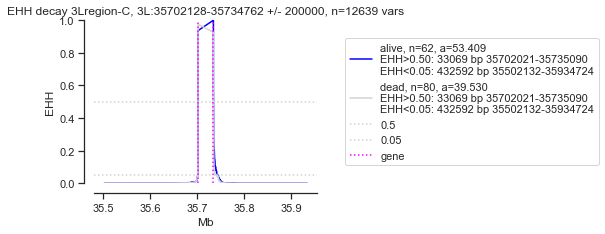

In [15]:
# variants to retain
clu_varbool_up = np.logical_and(oc_hapvars_seg["POS"] >= loc_start-flank_bp_EHH, oc_hapvars_seg["POS"] < loc_start)
clu_varbool_do = np.logical_and(oc_hapvars_seg["POS"] > loc_end, oc_hapvars_seg["POS"] <= loc_end+flank_bp_EHH)
clu_varbool    = np.logical_or(clu_varbool_up,clu_varbool_do)

# samples to remove from analysis (EHH function can't handle missing -1 data)
rmv_miss_ix   = np.unique(np.where(oc_haploty_hap_seg.subset(sel0=clu_varbool) == -1)[1]).tolist()
rmv_miss_bool = np.invert(np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=rmv_miss_ix))

# positions
clu_ehh_pos = oc_hapvars_seg["POS"].subset(sel0=clu_varbool)

# plot
pdf = PdfPages("%s/sel_%s_EHHdecay.pdf" % (outdir,l_nom))
fig = plt.figure(figsize=(4,3))
ax3 = plt.subplot(1, 1, 1)

for i,clu_key in enumerate(popdich_clu.keys()):

    print("EHH %s" % clu_key)

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)
    
    # calculate actual EHH
    clu_ehh_up_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_up,sel1=clu_sambool))
    clu_ehh_do_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_do,sel1=clu_sambool))
    clu_ehh_i    = np.concatenate((clu_ehh_up_i[::-1],clu_ehh_do_i))
    clu_ehh_i_ar = np.trapz(clu_ehh_i)
    ehh_above_start = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[0]
    ehh_above_end   = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[-1]
    ehh_below_start = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[0]
    ehh_below_end   = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[-1]

    # lab is data
    clu_lab    = "%s, n=%i, a=%.3f\nEHH>%.2f: %i bp %i-%i\nEHH<%.2f: %i bp %i-%i" % (
        clu_key, len(popdich_clu[clu_key]),clu_ehh_i_ar, 
        ehh_above_thr, ehh_above_end-ehh_above_start, ehh_above_start, ehh_above_end,
        ehh_below_thr, ehh_below_end-ehh_below_start, ehh_below_start, ehh_below_end
    )
    
    # plot EHH background & foreground
    ax3.plot(clu_ehh_pos/1e6,clu_ehh_i,color=colors[i],label=clu_lab,mfc='none')

sns.despine(ax=ax3,offset=10)
ax3.set_title("EHH decay %s, %s:%i-%i +/- %i, n=%s vars" % (l_nom,chrom,loc_start,loc_end,flank_bp_EHH,clu_ehh_pos.shape[0]))
ax3.set_xlabel("Mb")
ax3.set_ylabel("EHH")
ax3.set_ylim(0,1)
plt.axhline(ehh_above_thr, color='lightgray',linestyle=":",label=str(ehh_above_thr))
plt.axhline(ehh_below_thr, color='lightgray',linestyle=":",label=str(ehh_below_thr))
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="gene")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

### Garud H and haplotype diversity

Compute **Garud H statistics and haplotype diversity** for each cluster and estimates in the region of interest. Plots represent a wide region around the gene, and statistics are estimated from variants within the cluster only.

In [16]:
# variants to examine
block_size = 200

# region to plot
flanking_bp = 2e5
clu_varbool = np.logical_and(
    oc_hapvars_seg["POS"] >= loc_start-flanking_bp,
    oc_hapvars_seg["POS"] <= loc_end+flanking_bp)

# region to focus: statistics will be calcualted in this region
clu_varbool_focus = np.logical_and(oc_hapvars_seg["POS"] > loc_start-flank_bp_EHH, oc_hapvars_seg["POS"] <= loc_end+flank_bp_EHH)

First, for H12 plot:

alive
H12 = 0.057676 +/- 0.008738 SE, n = 62
dead
H12 = 0.046314 +/- 0.003243 SE, n = 80


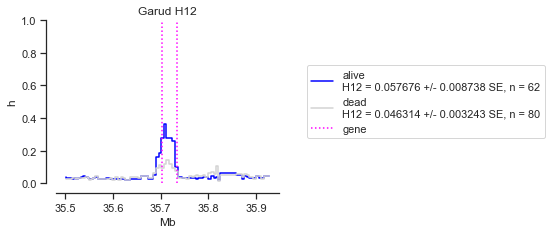

In [17]:
# open PDF
pdf = PdfPages("%s/sel_%s_GarudH12.pdf" % (outdir,l_nom))
fig = plt.figure(figsize=(4,3))
ax9 = plt.subplot(1, 1, 1)

for i,clu_key in enumerate(popdich_clu.keys()):

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)

    # Garud H along chromosome
    clu_pos_wib = allel.moving_statistic(
        oc_hapvars_seg["POS"].subset(sel0=clu_varbool), statistic=lambda v: v[0], size=block_size)
    clu_gah_wib = allel.moving_garud_h(
        oc_haploty_hap_seg.subset(sel0=clu_varbool,sel1=clu_sambool), size=block_size)
    
    # garud in focus region
    gah_focus_est = allel.moving_garud_h(oc_haploty_hap_seg.subset(sel0=clu_varbool_focus, sel1=clu_sambool), size=block_size)
    gah_focus_est_jack = allel.stats.misc.jackknife(gah_focus_est[1], statistic=np.nanmean)
    clu_label = "%s\nH12 = %.6f +/- %.6f SE, n = %i" % (clu_key, gah_focus_est_jack[0], gah_focus_est_jack[1],np.sum(clu_sambool))
    print(clu_label)

    # plot
    plt.step(clu_pos_wib/1e6, clu_gah_wib[1], color=colors[i], label=clu_label)
    

sns.despine(ax=ax9,offset=10)
ax9.set_title("Garud H12")
ax9.set_ylim(0,1)
ax9.set_xlabel("Mb")
ax9.set_ylabel("h")
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="gene")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax9.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

Now, same with H2/H1 plot:

alive
H2H1 = 0.719872 +/- 0.029586 SE, n = 62
dead
H2H1 = 0.660247 +/- 0.025544 SE, n = 80


/home/xavi/miniconda3/envs/ace/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/xavi/miniconda3/envs/ace/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


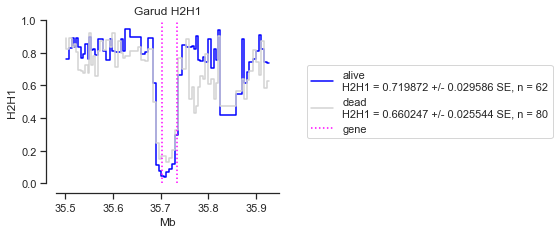

In [18]:
# open PDF
pdf = PdfPages("%s/sel_%s_GarudH2H1.pdf" % (outdir,l_nom))
fig = plt.figure(figsize=(4,3))
ax9 = plt.subplot(1, 1, 1)

for i,clu_key in enumerate(popdich_clu.keys()):

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)

    # Garud H along chromosome
    clu_pos_wib = allel.moving_statistic(
        oc_hapvars_seg["POS"].subset(sel0=clu_varbool), statistic=lambda v: v[0], size=block_size)
    clu_gah_wib = allel.moving_garud_h(
        oc_haploty_hap_seg.subset(sel0=clu_varbool,sel1=clu_sambool), size=block_size)
    
    # garud in focus region
    gah_focus_est = allel.moving_garud_h(oc_haploty_hap_seg.subset(sel0=clu_varbool_focus, sel1=clu_sambool), size=block_size)
    gah_focus_est_jack = allel.stats.misc.jackknife(gah_focus_est[3], statistic=np.nanmean)
    clu_label = "%s\nH2H1 = %.6f +/- %.6f SE, n = %i" % (clu_key, gah_focus_est_jack[0], gah_focus_est_jack[1],np.sum(clu_sambool))
    print(clu_label)

    # plot
    plt.subplot(1, 1, 1)
    plt.step(clu_pos_wib/1e6, clu_gah_wib[3], color=colors[i], label=clu_label)
    

sns.despine(ax=ax9,offset=10)
ax9.set_title("Garud H2H1")
ax9.set_ylim(0,1)
ax9.set_xlabel("Mb")
ax9.set_ylabel("H2H1")
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="gene")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax9.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

Finally, haplotype diversity:

alive
h = 0.970417 +/- 0.007016 SE, n = 62
dead
h = 0.978248 +/- 0.002416 SE, n = 80


/home/xavi/miniconda3/envs/ace/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/xavi/miniconda3/envs/ace/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


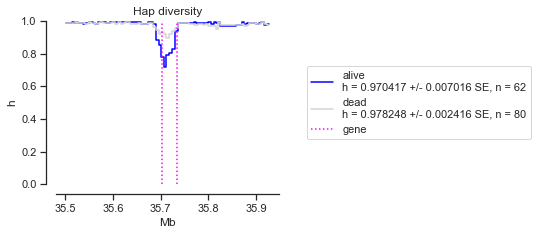

In [19]:
# open PDF
pdf = PdfPages("%s/sel_%s_hapdiv.pdf" % (outdir,l_nom))
fig = plt.figure(figsize=(4,3))
ax9 = plt.subplot(1, 1, 1)

for i,clu_key in enumerate(popdich_clu.keys()):

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)

    # hap div along chromosome
    clu_pos_wib = allel.moving_statistic(
        oc_hapvars_seg["POS"].subset(sel0=clu_varbool), statistic=lambda v: v[0], size=block_size)
    clu_hdi_wib = allel.moving_haplotype_diversity(
        oc_haploty_hap_seg.subset(sel0=clu_varbool,sel1=clu_sambool), size=block_size)
    
    # garud in focus region
    gah_focus_est = allel.moving_haplotype_diversity(oc_haploty_hap_seg.subset(sel0=clu_varbool_focus, sel1=clu_sambool), size=block_size)
    gah_focus_est_jack = allel.stats.misc.jackknife(gah_focus_est, statistic=np.nanmean)
    clu_label = "%s\nh = %.6f +/- %.6f SE, n = %i" % (clu_key, gah_focus_est_jack[0], gah_focus_est_jack[1],np.sum(clu_sambool))
    print(clu_label)

    # plot
    plt.subplot(1, 1, 1)
    plt.step(clu_pos_wib/1e6, clu_hdi_wib, color=colors[i], label=clu_label)
    
sns.despine(ax=ax9,offset=10)
ax9.set_title("Hap diversity")
ax9.set_ylim(0,1)
ax9.set_xlabel("Mb")
ax9.set_ylabel("h")
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="gene")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax9.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()